In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_cpu_use_thunk_runtime=false"
import jax, numpyro
import jax.numpy as jnp
from jax import config, random
config.update('jax_platform_name', 'cpu')
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 4
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

import numpy as np
import pandas as pd
from pathlib import Path
from jaxspec.specfit import SpecFit, SpecFit2, SpecFitN
from jaxspec.infer import *
from jaxspec.numpyro_model import model_single
from numpyro_model_sb3 import model_sb3
import sys, dill, corner

# jax device count: 4


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
def load_spectrum(datapath, orders, pct_threshold=10., numpix=3000, remove_trend=False):
    orders = np.atleast_1d(orders)
    data = pd.read_csv(datapath)
    wav_obs = np.array(data.lam).reshape(-1,numpix)[orders,:]
    flux_obs = np.array(data.flux).reshape(-1,numpix)[orders,:]
    error_obs = np.ones_like(flux_obs) * 5e-3
    mask_obs = ~(flux_obs == flux_obs)
    flux_obs = np.where(flux_obs == flux_obs, flux_obs, 1.)
    return [wav_obs, flux_obs, error_obs, mask_obs]

In [ ]:
gridpath = str(Path("~/data/specgrid_hdsYbred_coelho").expanduser()) + "/" # path to synthetic grid; can be downloaded from https://www.dropbox.com/scl/fi/l6d458qmauewrujpezyj5/specgrid_hdsYbred_coelho.tar.gz?rlkey=82b68is2qnxwbl383botbzrlc&dl=0
orders = np.arange(1,7)
physical_logg_max = True
empirical_vmacro = True
resolution = 90000
vmax = 50.

In [ ]:
wav_obs, flux_obs, error_obs, mask_obs = load_spectrum("data/subaru_250406_g1010_Yb_R12.csv", orders)
outstr = 'spectrum_output/'

## SB1 fit

In [38]:
sf = SpecFit(str(gridpath), [wav_obs, flux_obs, error_obs, mask_obs], orders, vmax=vmax, wav_margin=3.)
sf.wavresmin = np.array([resolution] * len(sf.orders))
sf.wavresmax = np.array([resolution] * len(sf.orders))

In [39]:
sf.check_ccf(output_dir=outstr)

# order 1
# order 2
# order 3
# order 4
# order 5
# order 6


(4.7496584931977, 9.840984098409834)

In [40]:
param_bounds = get_parameter_bounds(sf, vsini_max=15.)

In [41]:
p_fit = optim_svi(model_single, 1e-2, 5000, sf=sf, param_bounds=param_bounds) 

100%|██████████| 5000/5000 [01:34<00:00, 52.71it/s, init loss: -38290.5172, avg. loss [4751-5000]: -61468.9844]


In [42]:
sf.mask_outliers(p_fit, mask_v=10., output_dir=outstr)

In [43]:
sf.check_residuals(p_fit, output_dir=outstr)

## residual CCF

In [14]:
res_obs = []
for i in range(len(orders)):
    res_obs.append(sf.sm.flux_obs[i] - p_fit['fluxmodel'][i])
res_obs = np.array(res_obs)

sf_res = SpecFit2(str(gridpath), [wav_obs, res_obs, error_obs, mask_obs], orders, vmax=100., wav_margin=3.)
sf_res.wavresmin = np.array([resolution] * len(sf.orders))
sf_res.wavresmax = np.array([resolution] * len(sf.orders))

sf_res.check_ccf(output_dir=outstr, tag='_residual', ylim_tuple=(-0.4, 1.2));

# order 1
# order 2
# order 3
# order 4
# order 5
# order 6


/Users/k_masuda/miniforge3/envs/thunkrt/lib/python3.12/site-packages/jaxopt/_src/scipy_wrappers.py:341: OptimizeWarning: Unknown solver options: maxiter
  res = osp.optimize.minimize(scipy_fun, jnp_to_onp(init_params, self.dtype),


In [15]:
rv1 = np.median(sf.ccfrvlist)
rvshift2 = sf_res.v1 - rv1 
rvshift3 = sf_res.v2 - rv1
print(rvshift2, rvshift3)

-53.21595977459865 20.605500041545532


## SB3 fit

In [16]:
sf3 = SpecFitN(str(gridpath), [wav_obs, flux_obs, error_obs, mask_obs], orders, vmax=vmax, wav_margin=3.)
sf3.wavresmin = np.array([resolution] * len(sf.orders))
sf3.wavresmax = np.array([resolution] * len(sf.orders))

In [17]:
p_fit = optim_svi(model_sb3, 1e-2, 5000, rvshift2=rvshift2, rvshift3=rvshift3, sf=sf3, param_bounds=param_bounds) 

100%|██████████| 5000/5000 [04:29<00:00, 18.52it/s, init loss: 23976.5314, avg. loss [4751-5000]: -62038.7476]


In [18]:
sf3.mask_outliers(p_fit, mask_v=10., output_dir=outstr, tag='_sb3')

In [19]:
sf3.check_residuals(p_fit, output_dir=outstr, tag='_sb3')

In [20]:
# optimize again
p_fit = optim_svi(model_sb3, 1e-2, 2000, rvshift2=rvshift2, rvshift3=rvshift3, sf=sf3, param_bounds=param_bounds, p_initial=p_fit) 

100%|██████████| 2000/2000 [02:34<00:00, 12.92it/s, init loss: -61889.2282, avg. loss [1901-2000]: -62165.2415]


In [84]:
import pickle
with open("g1010_sf3.pkl", "wb") as f:
    pickle.dump(sf3, f)

## posterior sampling

In [21]:
from numpyro.infer import init_to_value
kernel = numpyro.infer.NUTS(model_sb3, init_strategy=init_to_value(values=p_fit), dense_mass=True)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=num_chains)

In [22]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sf=sf3, param_bounds=param_bounds, rvshift2=rvshift2, rvshift3=rvshift3)
mcmc.print_summary()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha_common_scaled      0.02      0.01      0.01      0.00      0.04   4442.02      1.00
                   f2      0.09      0.00      0.09      0.09      0.10   3815.83      1.00
                   f3      0.07      0.00      0.07      0.07      0.08   3987.28      1.00
    feh_common_scaled      0.37      0.01      0.37      0.36      0.38   3803.67      1.00
                  lna     -4.64      0.01     -4.64     -4.67     -4.62   4060.28      1.00
                  lnc     -2.17      0.02     -2.17     -2.20     -2.14   4728.82      1.00
              lnsigma     -9.61      0.28     -9.67    -10.00     -9.21   3772.37      1.00
       logg_scaled[0]      0.69      0.02      0.69      0.66      0.72   4255.10      1.00
       logg_scaled[1]      0.66      0.08      0.66      0.54      0.80   1497.09      1.00
       logg_scaled[2]      0.65      0.11      0.65      0.49      0.83   1002.

In [23]:
smp = mcmc.get_samples()
ms, mgps = get_mean_models(smp, sf3)
sf3.plot_models(ms, mgps=mgps, output_dir=outstr, head='sb3_')

In [ ]:
import arviz as az 
idata = az.from_numpyro(mcmc)
#idata.to_json(f"{outstr}chains.json")

In [ ]:
idata_ = idata.copy()
vars_to_remove = ["fluxmodel", "fluxmodel0"] + [f'flux_residual{i}' for i in range(6)]

for group in ["sample_stats", "posterior"]:
    if hasattr(idata_, group):
        ds = getattr(idata_, group)
        for v in vars_to_remove:
            if v in ds:
                ds = ds.drop_vars(v)
        setattr(idata_, group, ds)

idata_.to_json(f"{outstr}chains_parameters.json")

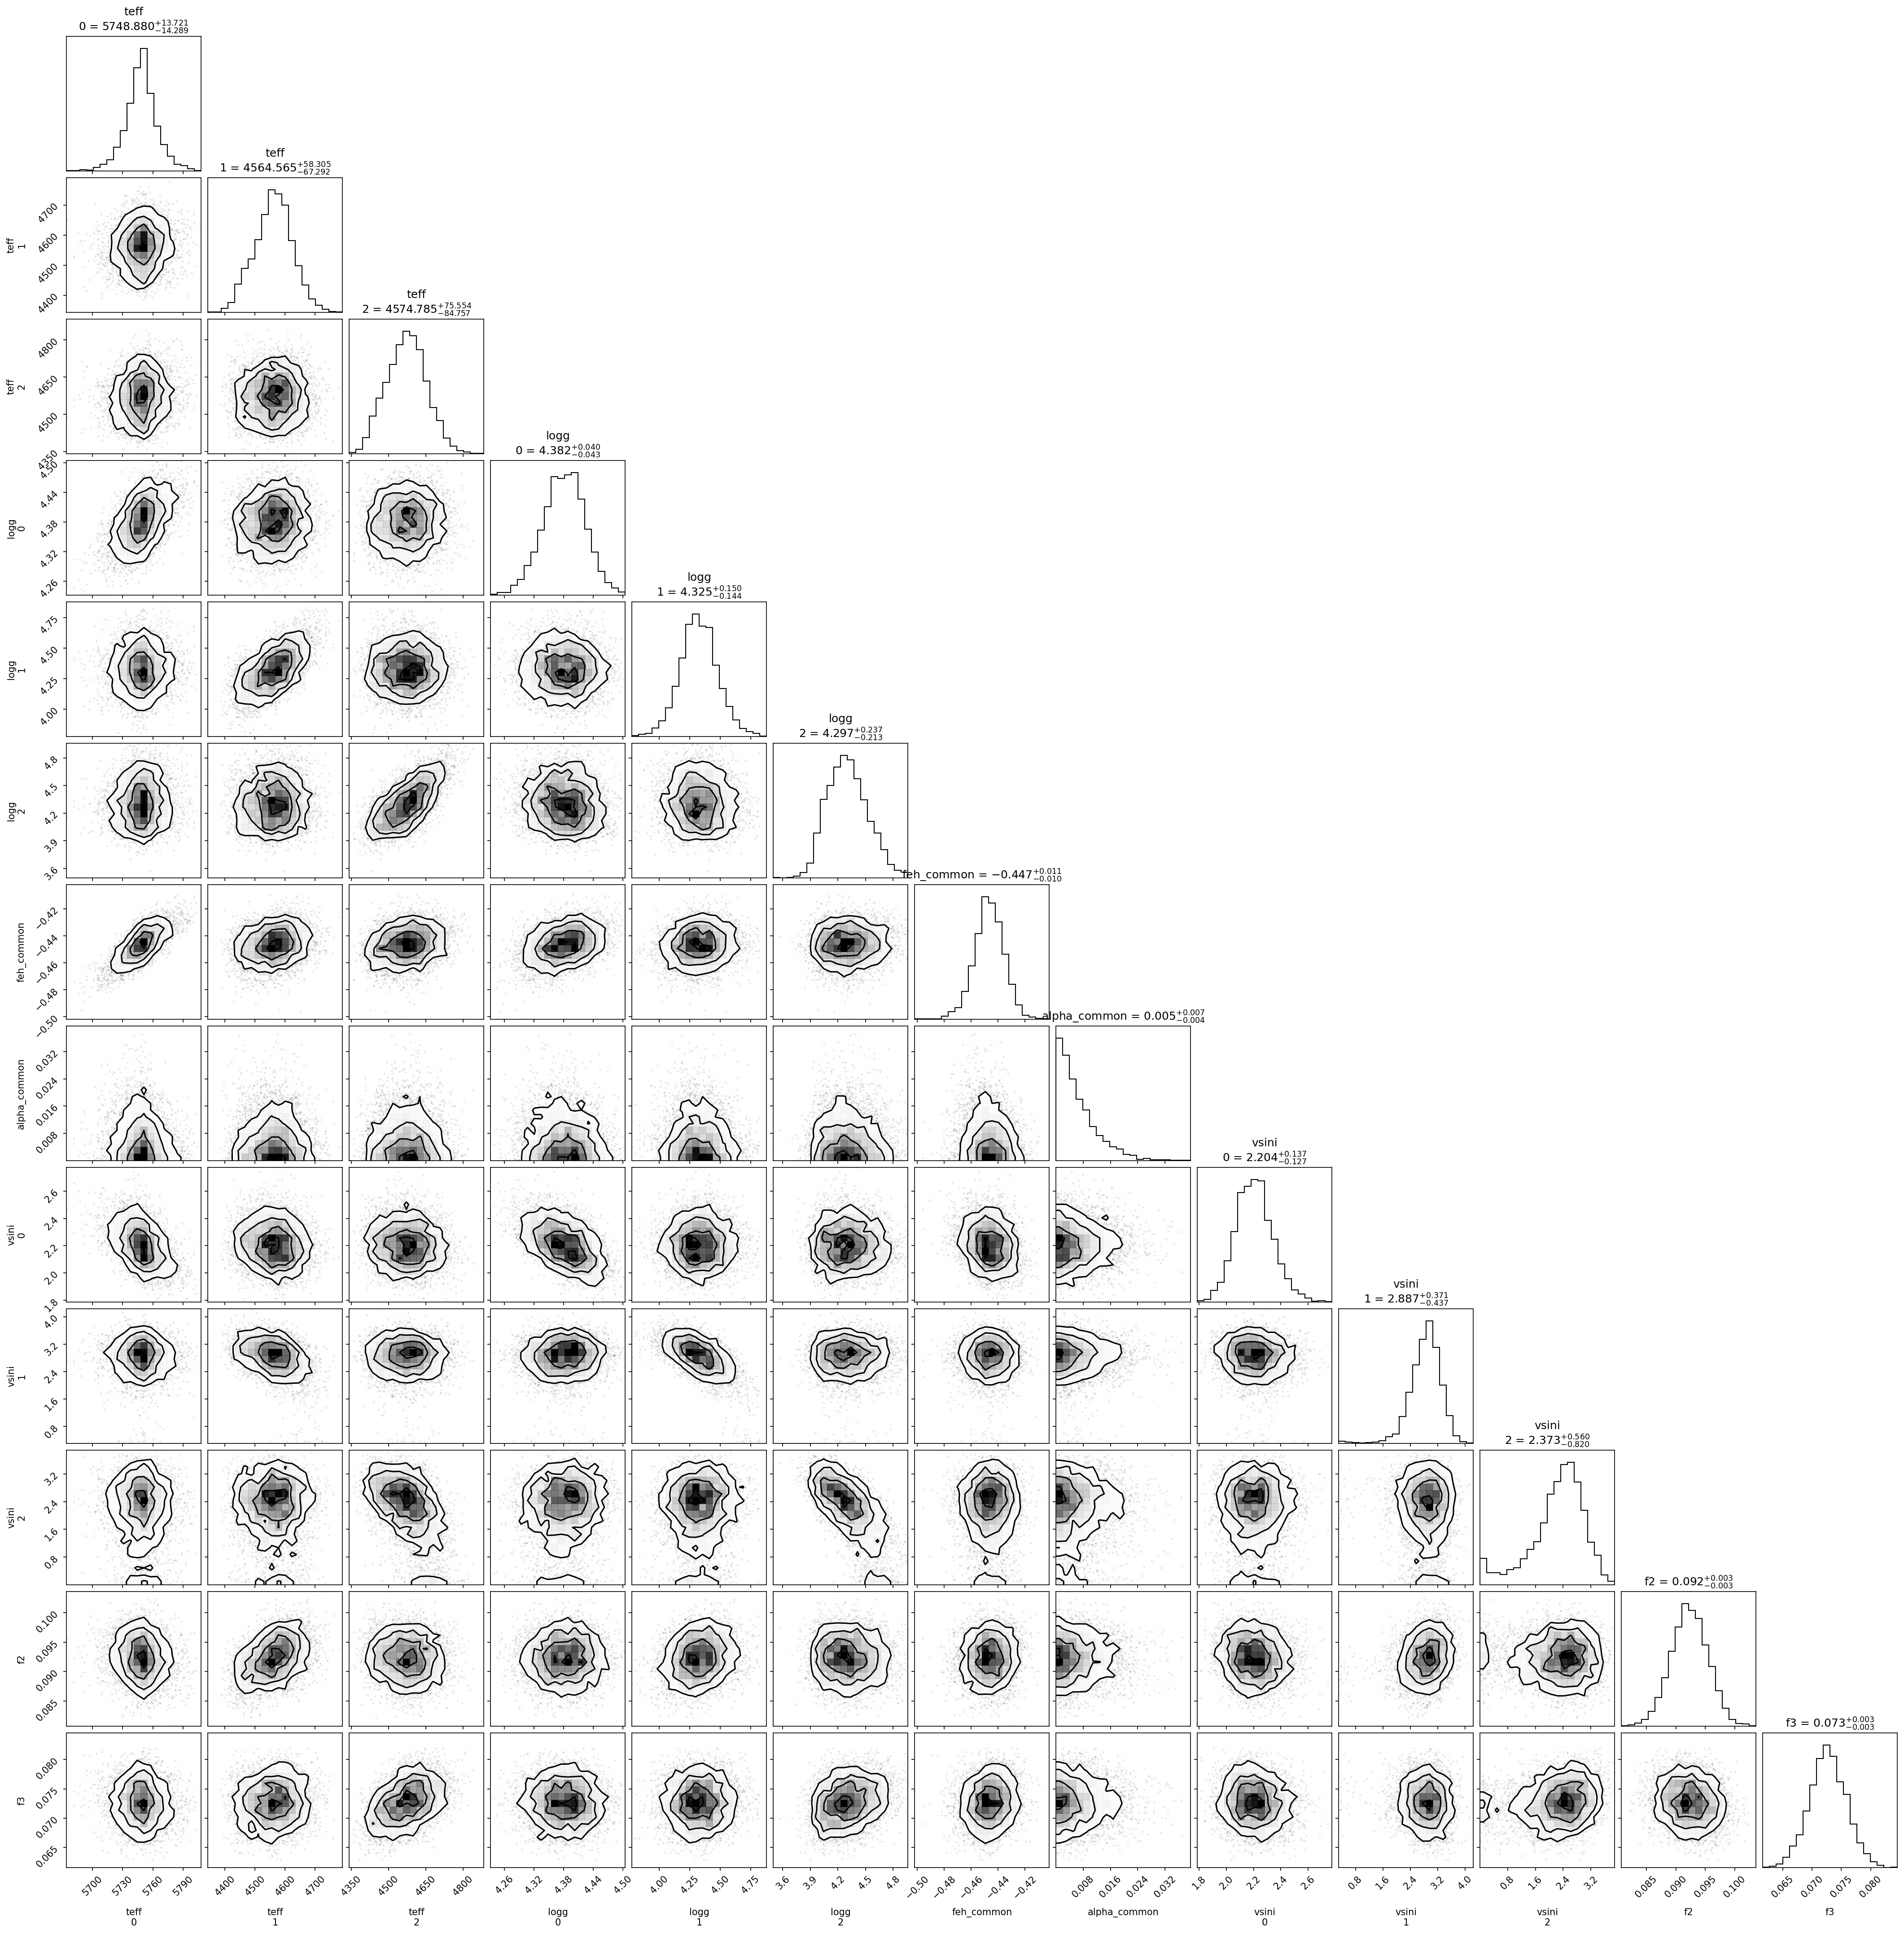

In [27]:
fig = corner.corner(idata, var_names=['teff', 'logg', 'feh_common', 'alpha_common', 'vsini', 'f2', 'f3'], show_titles=True, title_fmt=".3f")
plt.savefig(f"{outstr}corner.png", dpi=200, bbox_inches="tight")